In [3]:
import pandas as pd
from Bio import SeqIO 
from Bio import SearchIO
import numpy as np
import seaborn as sns

In [4]:
#DAP_SPECIES = "PSIMIAE"
DAP_SPECIES = "ECOLI"

In [5]:
annotated_hits_path =  f"../data/{DAP_SPECIES}_RESULTS/ALL_FIMO_HITS_ANNOTATED.pkl"
accessions_path = f"../data/tf_sequences/{DAP_SPECIES}_tf_accessions.tsv"
col_names = ['tf_id', 'tf_acc']
df_complete = pd.read_pickle(annotated_hits_path)
df_tf_acc   = pd.read_csv(accessions_path, sep="\t", names=col_names)
df_tf_acc   = df_tf_acc.set_index('tf_id')

In [6]:
df_tf_acc_vs_id = df_tf_acc.reset_index().set_index('tf_acc')

In [7]:
if DAP_SPECIES == "PSIMIAE":
    records = SeqIO.to_dict(SeqIO.parse("../data/refs/Pseudomonas_simiae_WCS417/Pseudomonas_simiae_WCS417.faa", "fasta"))
elif DAP_SPECIES == "ECOLI":
        records = SeqIO.to_dict(SeqIO.parse("../data/refs/Escherichia_coli_MG1655/Escherichia_coli_MG1655.faa", "fasta"))

In [8]:
with open("dummy.faa", "w+") as f:
    for index, row in df_tf_acc.iterrows():  
        acc = row['tf_acc']
        sequence = str(records[acc].seq)        
        f.write(f">{acc}\n{sequence}\n")
        #! printf ">"{acc}"\n"{sequence}"\n" > "dummy.faa"

In [9]:
%%bash

module load hmmer/3.1b2
hmmscan --tblout dummy.pfam.out -E 1e-9 ../data/pfam/Pfam-A.hmm dummy.faa > dummy.pfam.stdout 2>dummy.pfam.stderr

In [10]:
hit_list = []
for rec in SearchIO.parse("dummy.pfam.out", "hmmer3-tab"):
    tf_acc = rec.id
    tf_id  = df_tf_acc_vs_id.loc[tf_acc].tf_id
    for hit in rec.hits:
        hit_list += [[tf_id, tf_acc, hit.id, hit.accession, hit.description, hit.evalue, hit.domain_included_num]]

names = ['tf_id', 'tf_acc', 'hit_id', 'hit_accession', 'hit_desc', 'evalue', 'included']        
df_pfam = pd.DataFrame(hit_list, columns=names)
df_pfam['dummy_count'] = 1

joined_desc = [x+y for x,y in df_pfam[['hit_id','hit_desc']].values]
df_pfam['joined_desc'] = joined_desc

In [11]:
df_pfam.head()

tf_id       tf_acc          hit_id hit_accession  \
0  accB  NP_417721.1   Biotin_lipoyl    PF00364.23   
1  acrR  NP_414997.1        TetR_C_2    PF08361.12   
2  acrR  NP_414997.1          TetR_N    PF00440.24   
3   ada  NP_416717.1  Ada_Zn_binding    PF02805.17   
4   ada  NP_416717.1   DNA_binding_1    PF01035.21   

                                            hit_desc        evalue  included  \
0                            Biotin-requiring enzyme  3.900000e-25         1   
1  MAATS-type transcriptional repressor, C-termin...  6.900000e-52         1   
2         Bacterial regulatory proteins, tetR family  9.700000e-20         1   
3                        Metal binding domain of Ada  2.700000e-32         1   
4  6-O-methylguanine DNA methyltransferase, DNA b...  3.000000e-32         1   

   dummy_count                                        joined_desc  
0            1               Biotin_lipoylBiotin-requiring enzyme  
1            1  TetR_C_2MAATS-type transcriptional repressor, ...  
2            1   TetR_NBacterial regulatory proteins, tetR family  
3            1          Ada_Zn_bindingMetal binding domain of Ada  
4            1  DNA_binding_16-O-methylguanine DNA methyltrans...

In [38]:
hit.

[Hit(id='FUR', query_id='NP_418470.4', 1 hsps)]

In [12]:
for tf_id, df_group in df_pfam.groupby('tf_id'):
    print(df_group)
    #print("-"*30)     

  tf_id       tf_acc         hit_id hit_accession                 hit_desc  \
0  accB  NP_417721.1  Biotin_lipoyl    PF00364.23  Biotin-requiring enzyme   

         evalue  included  dummy_count                           joined_desc  
0  3.900000e-25         1            1  Biotin_lipoylBiotin-requiring enzyme  
  tf_id       tf_acc    hit_id hit_accession  \
1  acrR  NP_414997.1  TetR_C_2    PF08361.12   
2  acrR  NP_414997.1    TetR_N    PF00440.24   

                                            hit_desc        evalue  included  \
1  MAATS-type transcriptional repressor, C-termin...  6.900000e-52         1   
2         Bacterial regulatory proteins, tetR family  9.700000e-20         1   

   dummy_count                                        joined_desc  
1            1  TetR_C_2MAATS-type transcriptional repressor, ...  
2            1   TetR_NBacterial regulatory proteins, tetR family  
  tf_id       tf_acc           hit_id hit_accession  \
3   ada  NP_416717.1   Ada_Zn_binding   

In [13]:
#df_tf_pfam_vectors = pd.pivot(df_pfam, index='tf_id', columns='hit_accession', values='dummy_count').fillna(0)
df_tf_pfam_vectors_complete = pd.crosstab(df_pfam.tf_id, df_pfam.hit_id)
df_tf_pfam_vectors = df_tf_pfam_vectors_complete.copy() 

## Remove singleton pfams and their TFs

In [14]:
pfam_counts = df_tf_pfam_vectors.sum().sort_values(ascending=False)
print("Removing singleton PFAM hits: ")
for pfam, occurrence in pfam_counts.iteritems():
    if occurrence <= 1:
        print(pfam, end=", ")
        df_tf_pfam_vectors.drop(pfam, axis=1, inplace=True)

# Remove associated TFs        
removal_filter = (df_tf_pfam_vectors != 0).any(axis=1)
df_tf_pfam_vectors = df_tf_pfam_vectors[removal_filter]

Removing singleton PFAM hits: 
Fe_dep_repress, GutM, FlhC, GGDEF_2, GAF_3, FlhD, tRNA_SAD, Fe_dep_repr_C, Bac_DnaA, ATP-cone, Acyl-CoA_dh_1, Acyl-CoA_dh_M, Ada_Zn_binding, AidB_N, Aldedh, AraC_N, AraC_binding_2, Arg_repressor, Arg_repressor_C, Autoind_bind, BPL_C, BPL_LplA_LipB, Bac_DnaA_C, FadR_C, Biotin_lipoyl, BolA, CSD, CadC_C1, CecR_C, Couple_hipA, Crp, Cupin_6, DHHA1, DNA_binding_1, Diacid_rec, DnaA_N, EAL, Cupin_2, HigB_toxin, HTH_11, SgrR_N, Phage_AlpA, Phage_int_SAM_1, PhdYeFM_antitox, Pro_dh, Pro_dh-DNA_bdg, PrpR_N, RHH_1, RtcR, SBP_bac_5, SIS_2, Sigma70_r4_2, HTH_20, Sugar-bind, TOBE, TPR_MalT, TetR_C_13, TetR_C_3, TetR_C_6, Trp_repressor, UTRA, YafQ_toxin, YoeB_toxin, Peptidase_S24, Peptidase_M17_N, Peptidase_M17, PemK_toxin, HTH_27, HTH_30, HTH_5, HTH_50, tRNA-synt_2c, HipA_C, IstB_IS21, LexA_DNA_bind, MarR_2, MazE_antitoxin, MetJ, Methyltransf_1N, MqsA_antitoxin, MraZ, NikR_C, PAS, PRODH, PaaX, PaaX_C, PadR, ParE_toxin, AAA_28, 

In [35]:
df_pfam

tf_id       tf_acc           hit_id hit_accession  \
0    accB  NP_417721.1    Biotin_lipoyl    PF00364.23   
1    acrR  NP_414997.1         TetR_C_2    PF08361.12   
2    acrR  NP_414997.1           TetR_N    PF00440.24   
3     ada  NP_416717.1   Ada_Zn_binding    PF02805.17   
4     ada  NP_416717.1    DNA_binding_1    PF01035.21   
..    ...          ...              ...           ...   
427  zraR  NP_418432.1  Sigma54_activat    PF00158.27   
428  zraR  NP_418432.1     Response_reg    PF00072.25   
429  zraR  NP_418432.1  Sigma54_activ_2     PF14532.7   
430  zraR  NP_418432.1            HTH_8    PF02954.20   
431   zur  NP_418470.4              FUR    PF01475.20   

                                              hit_desc        evalue  \
0                              Biotin-requiring enzyme  3.900000e-25   
1    MAATS-type transcriptional repressor, C-termin...  6.900000e-52   
2           Bacterial regulatory proteins, tetR family  9.700000e-20   
3                          Metal binding domain of Ada  2.700000e-32   
4    6-O-methylguanine DNA methyltransferase, DNA b...  3.000000e-32   
..                                                 ...           ...   
427                        Sigma-54 interaction domain  1.500000e-71   
428                 Response regulator receiver domain  1.300000e-30   
429                        Sigma-54 interaction domain  2.000000e-24   
430           Bacterial regulatory protein, Fis family  4.100000e-15   
431                     Ferric uptake regulator family  2.900000e-15   

     included  dummy_count                                        joined_desc  
0           1            1               Biotin_lipoylBiotin-requiring enzyme  
1           1            1  TetR_C_2MAATS-type transcriptional repressor, ...  
2           1            1   TetR_NBacterial regulatory proteins, tetR family  
3           1            1          Ada_Zn_bindingMetal binding domain of Ada  
4           1            1  DNA_binding_16-O-methylguanine DNA methyltrans...  
..        ...          ...                                                ...  
427         1            1         Sigma54_activatSigma-54 interaction domain  
428         1            1     Response_regResponse regulator receiver domain  
429         1            1         Sigma54_activ_2Sigma-54 interaction domain  
430         1            1      HTH_8Bacterial regulatory protein, Fis family  
431         1            1                  FURFerric uptake regulator family  

[432 rows x 9 columns]

----------------------------------------

# Debug

In [16]:
df_tf_pfam_vectors.columns

Index(['AraC_binding', 'AsnC_trans_reg', 'Bac_DNA_binding', 'DeoRC', 'FCD',
       'FUR', 'GAF', 'GAF_2', 'GerE', 'GntR', 'GyrI-like', 'HTH_1', 'HTH_18',
       'HTH_24', 'HTH_3', 'HTH_31', 'HTH_6', 'HTH_8', 'HTH_AraC',
       'HTH_AsnC-type', 'HTH_Crp_2', 'HTH_DeoR', 'HTH_IclR', 'Histone_HNS',
       'IclR', 'LacI', 'LysR_substrate', 'LytTR', 'MarR', 'MerR',
       'MerR-DNA-bind', 'MerR_1', 'Peripla_BP_1', 'Peripla_BP_3',
       'Peripla_BP_4', 'ROK', 'RelB', 'Response_reg', 'Rrf2', 'SIS',
       'Sigma54_activ_2', 'Sigma54_activat', 'TetR_C_2', 'TetR_N',
       'Trans_reg_C', 'Trns_repr_metal', 'cNMP_binding'],
      dtype='object', name='hit_id')

In [17]:
for index, item in df_tf_pfam_vectors.Response_reg.iteritems():
    if item > 0:
        print("{}\t\t\t{}".format(index, item))
        break

arcA			1


In [18]:
df_tf_pfam_vectors.iloc[[1,2,3]]

hit_id  AraC_binding  AsnC_trans_reg  Bac_DNA_binding  DeoRC  FCD  FUR  GAF  \
tf_id                                                                         
ada                0               0                0      0    0    0    0   
adiY               0               0                0      0    0    0    0   
agaR               0               0                0      1    0    0    0   

hit_id  GAF_2  GerE  GntR  ...  Response_reg  Rrf2  SIS  Sigma54_activ_2  \
tf_id                      ...                                             
ada         0     0     0  ...             0     0    0                0   
adiY        0     0     0  ...             0     0    0                0   
agaR        0     0     0  ...             0     0    0                0   

hit_id  Sigma54_activat  TetR_C_2  TetR_N  Trans_reg_C  Trns_repr_metal  \
tf_id                                                                     
ada                   0         0       0            0                0   
adiY                  0         0       0            0                0   
agaR                  0         0       0            0                0   

hit_id  cNMP_binding  
tf_id                 
ada                0  
adiY               0  
agaR               0  

[3 rows x 47 columns]

In [32]:
[domain if "bind" in domain.lower() else "" for domain in df_tf_pfam_vectors_complete.columns ]

['',
 '',
 '',
 '',
 'Ada_Zn_binding',
 '',
 '',
 '',
 'AraC_binding',
 'AraC_binding_2',
 '',
 '',
 '',
 'Autoind_bind',
 '',
 '',
 'Bac_DNA_binding',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'DNA_binding_1',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'LexA_DNA_bind',
 '',
 '',
 '',
 '',
 '',
 '',
 'MerR-DNA-bind',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Sugar-bind',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'cNMP_binding',
 '',
 '']

------------------------

# Plot clusters

In [19]:
L = len(df_tf_pfam_vectors)
palette = sns.color_palette()
default_colors = ['w']*L
colors = np.array(default_colors, dtype='object')

if DAP_SPECIES == "PSIMIAE":
    major_pfams = [
           'GntR', 
           'HTH_18',
           'LysR_substrate',       
           'TetR_N',
           'Sigma54_activat',
           'LacI', 
           'MerR',
           'HTH_22',
           'HTH_6',
           'HTH_IclR',
           'Peptidase_S24',
           'HTH_AsnC-type'
            ]
    color_list = ['w', 'pink', 'lightgreen', 'c', 'g', 'orange', 'gold', 'plum', 'lightsteelblue', 'olive', 'grey', 'y', 'lightblue' ]
    
elif DAP_SPECIES == "ECOLI":
    #major_pfams = df_tf_pfam_vectors.sum().sort_values(ascending=False).head(12).index
    major_pfams = [
        'AsnC_trans_reg', 
        'GerE', 
        'GntR', 
        'HTH_AraC',
        'IclR', 
        'LacI', 
        'LysR_substrate', 
        'MerR', 
        'Sigma54_activat', 
        'TetR_N',
        'Trans_reg_C',
        'DeoRC',
        'Bac_DNA_binding',
        'HTH_3',
        'MarR'
    ]
    color_list = ['w', 'pink', 'lightgreen', 'c', 'g', 'orange', 'gold', 'plum', 'lightsteelblue', 'olive', 'grey', 'y', 'lightblue', 'lightgrey', 'beige', 'lightsalmon' ]


# Assign a color id to prominent pfams
for colorno, pfam in enumerate(major_pfams, 1):
    select_pfam = df_tf_pfam_vectors[pfam] >= 1
    colors[select_pfam] = color_list[colorno]
    print(pfam, "\t\t\t", color_list[colorno])
    
df_colors = pd.DataFrame(df_tf_pfam_vectors.index)
df_colors['class'] = colors
df_colors.set_index('tf_id', inplace=True)
df_colors.to_pickle(f'tf_class_colors_{DAP_SPECIES}.pkl.gz')
print(major_pfams)

AsnC_trans_reg 			 pink
GerE 			 lightgreen
GntR 			 c
HTH_AraC 			 g
IclR 			 orange
LacI 			 gold
LysR_substrate 			 plum
MerR 			 lightsteelblue
Sigma54_activat 			 olive
TetR_N 			 grey
Trans_reg_C 			 y
DeoRC 			 lightblue
Bac_DNA_binding 			 lightgrey
HTH_3 			 beige
MarR 			 lightsalmon
['AsnC_trans_reg', 'GerE', 'GntR', 'HTH_AraC', 'IclR', 'LacI', 'LysR_substrate', 'MerR', 'Sigma54_activat', 'TetR_N', 'Trans_reg_C', 'DeoRC', 'Bac_DNA_binding', 'HTH_3', 'MarR']


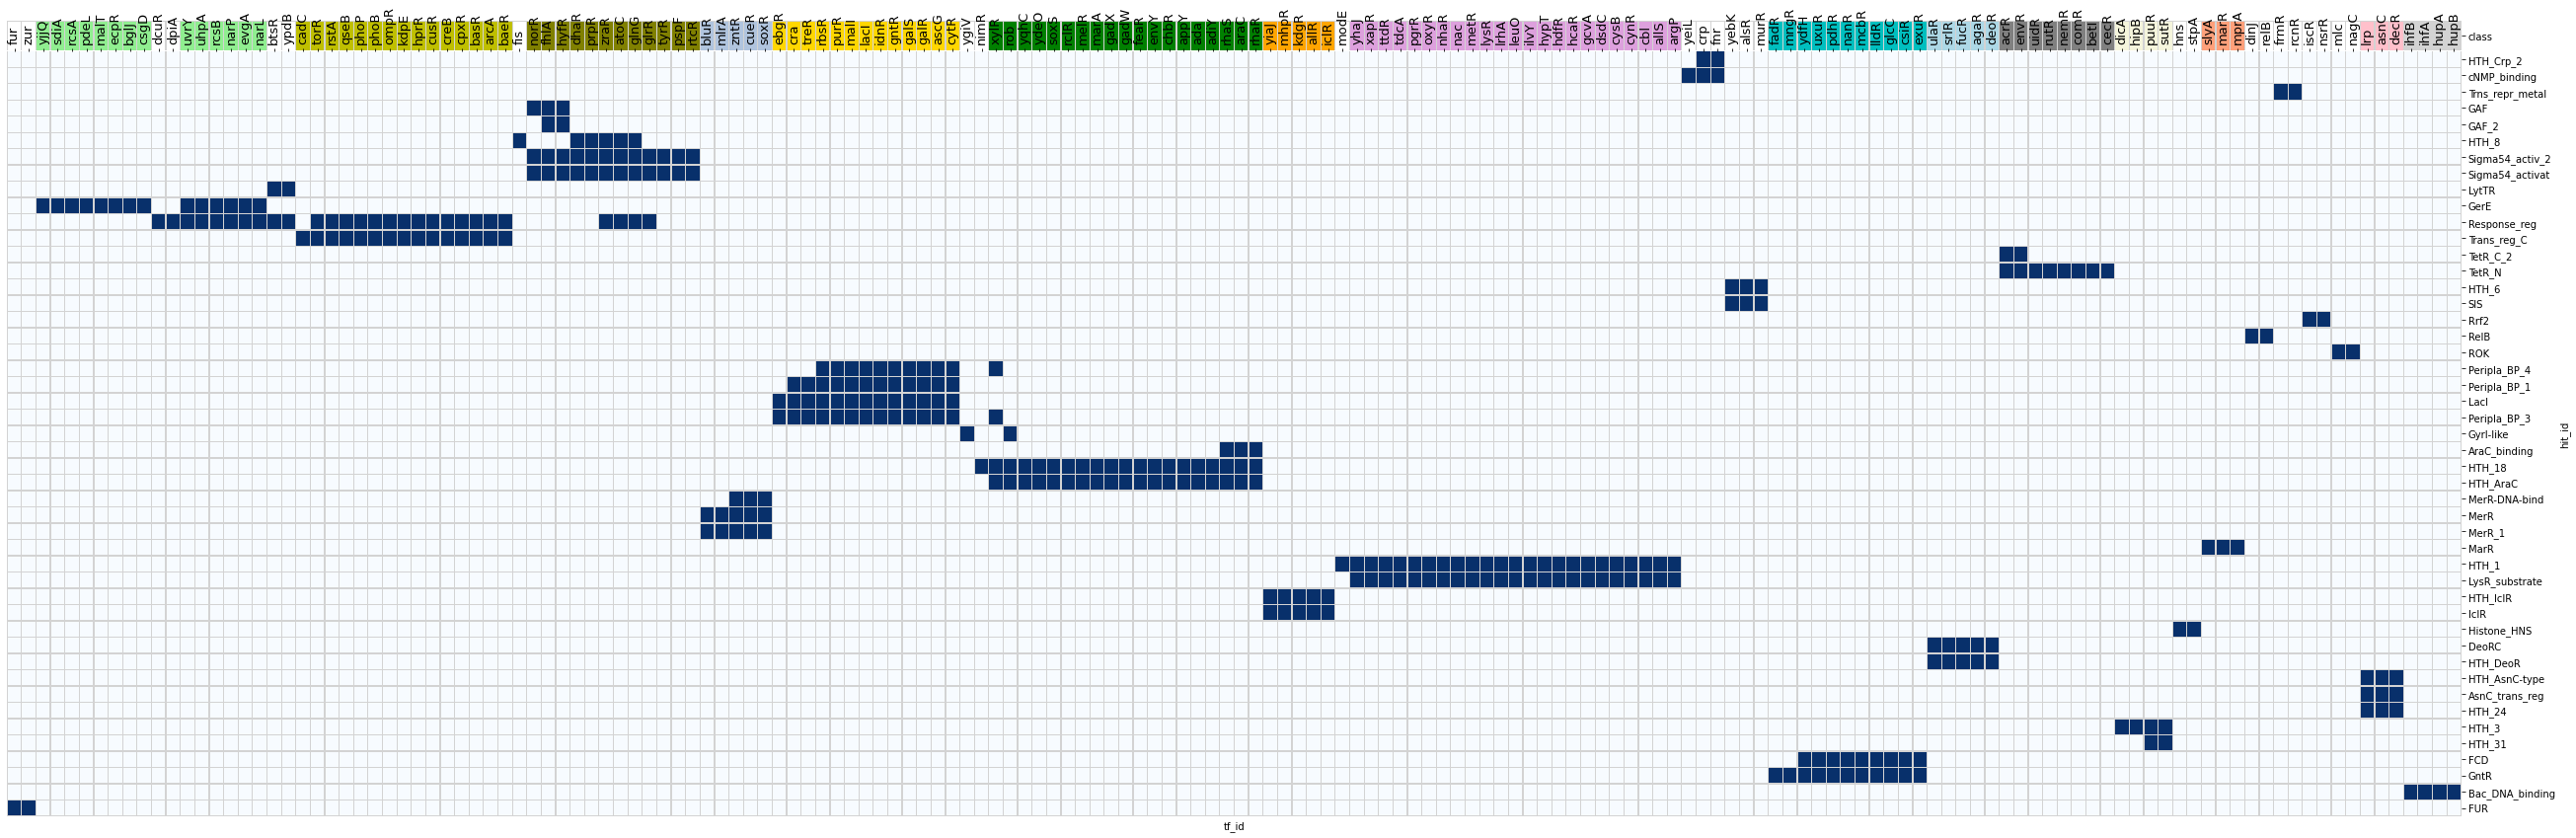

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
figsize = (45,15)

g = sns.clustermap(df_tf_pfam_vectors.transpose(), linewidths=0.2, linecolor='lightgrey', row_cluster=True, metric='jaccard', cmap='Blues', figsize=figsize, col_colors=df_colors)
g.ax_heatmap.xaxis.tick_top()
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation = 90, fontsize = 13)
g.ax_row_dendrogram.remove()
g.ax_col_dendrogram.remove()
g.cax.set_visible(False)
plt.show()

## Debug

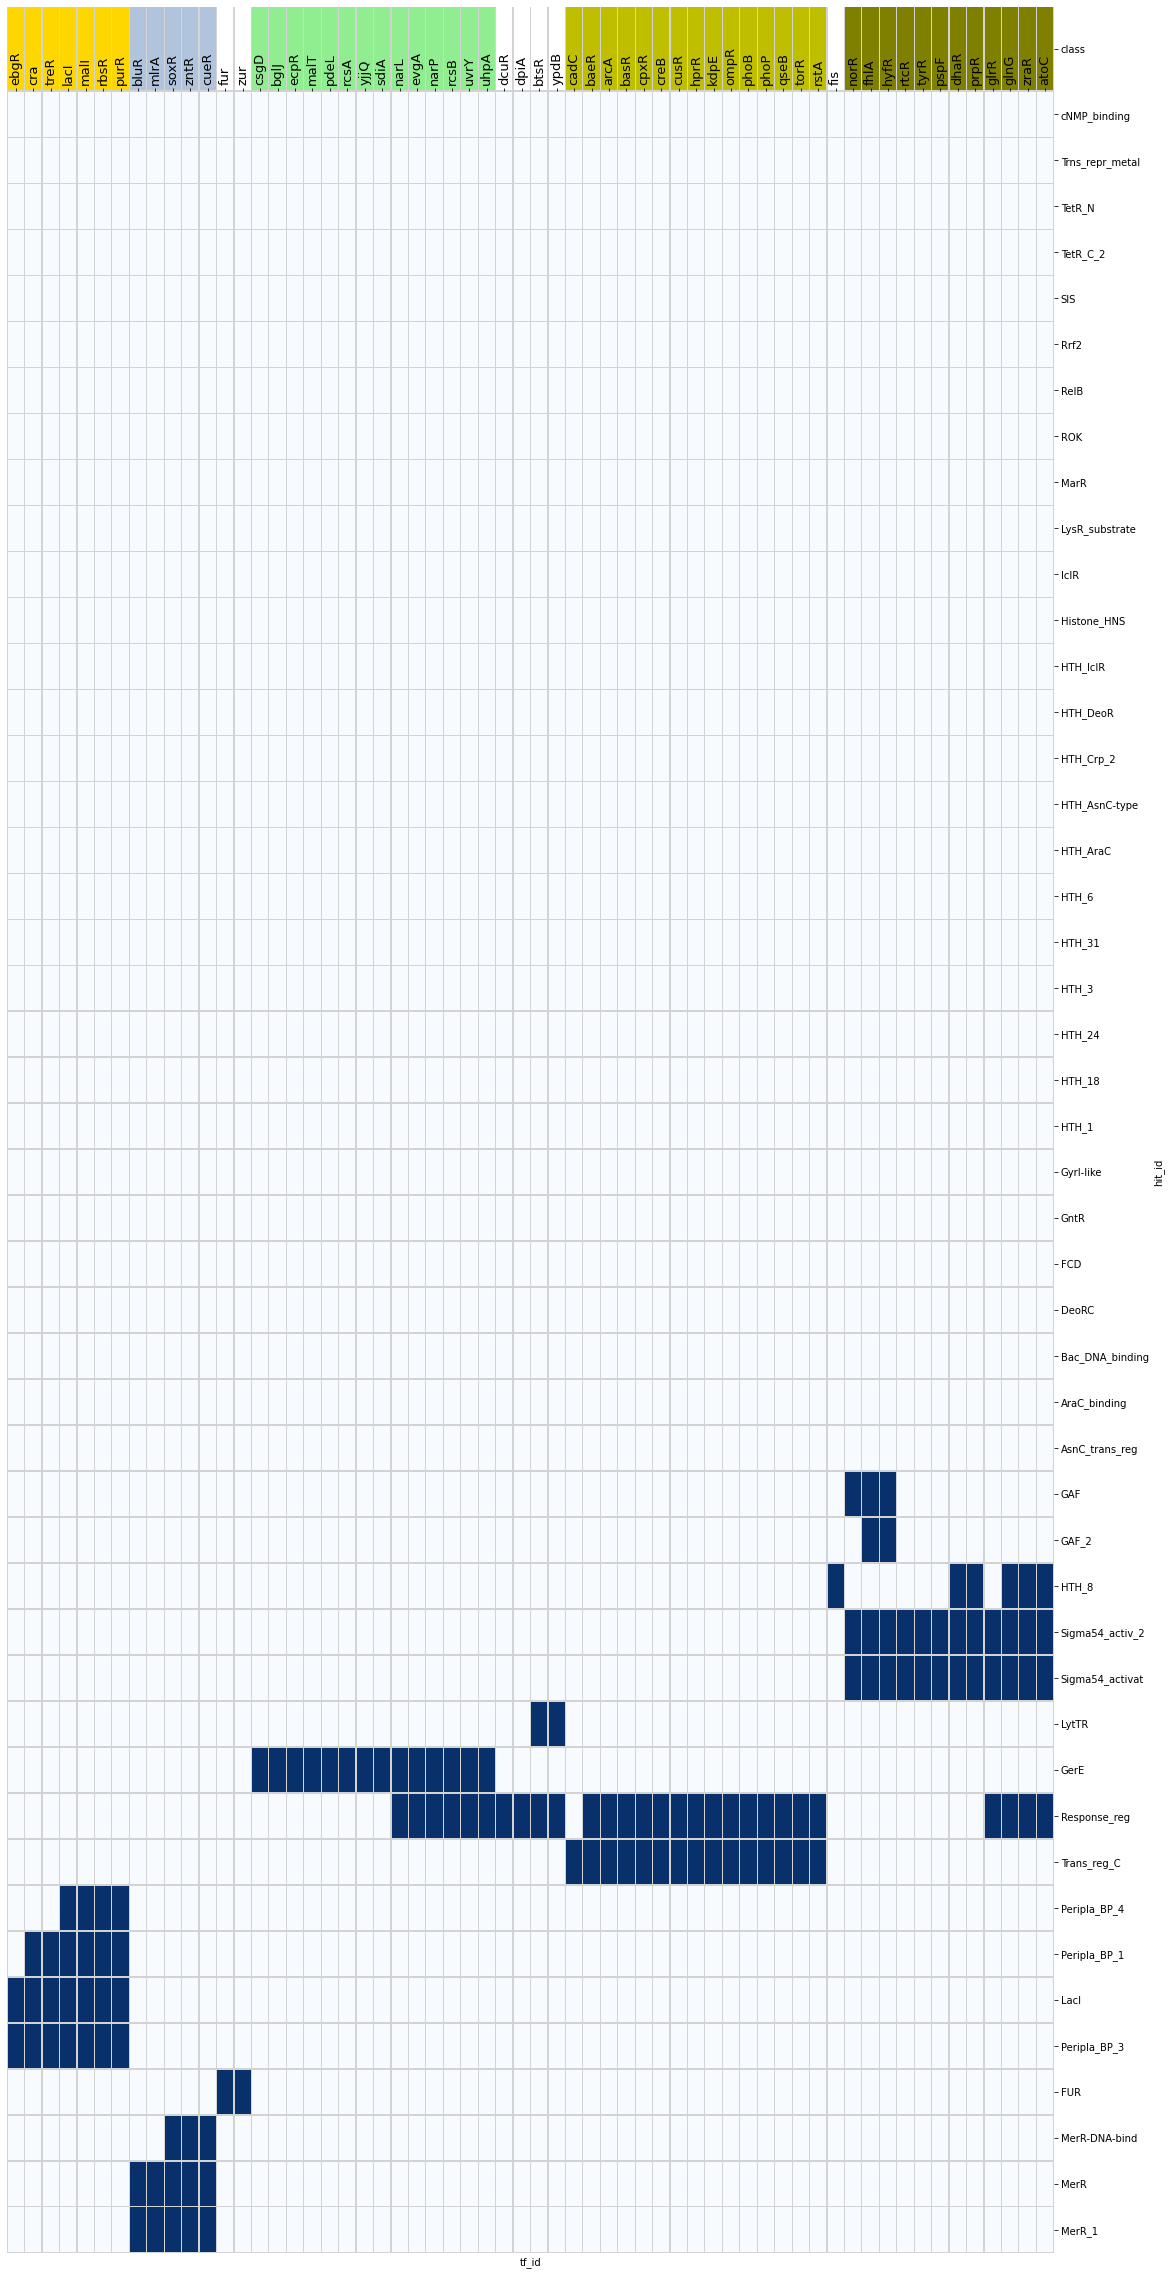

In [21]:
cols = g.dendrogram_col.reordered_ind[0:60]
figsize = (20,40)

g2 = sns.clustermap(df_tf_pfam_vectors.iloc[cols].transpose(), linewidths=0.2, linecolor='lightgrey', row_cluster=True, metric='jaccard', cmap='Blues', figsize=figsize, col_colors=df_colors)
g2.ax_heatmap.xaxis.tick_top()
g2.ax_heatmap.set_xticklabels(g2.ax_heatmap.get_xticklabels(), rotation = 90, fontsize = 13)
g2.ax_row_dendrogram.remove()
g2.ax_col_dendrogram.remove()
g2.cax.set_visible(False)
plt.show()

-----------------------------

# Umap

In [22]:
import umap
reducer = umap.UMAP(metric='jaccard')
embedding = reducer.fit_transform(df_tf_pfam_vectors_complete)

/global/homes/v/vsevim/.conda/envs/gpu/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1738: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/global/homes/v/vsevim/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


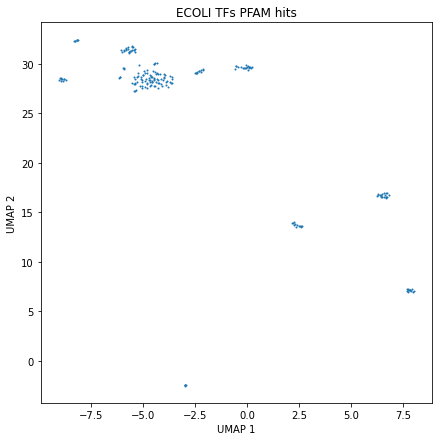

In [23]:
x = embedding[:, 0]
y = embedding[:, 1]
fig, ax = plt.subplots(figsize=(7,7))
plt.scatter(x, y, s=1)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title(f'{DAP_SPECIES} TFs PFAM hits')
plt.show()